In [2]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp, chi2_contingency ,kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Display settings or Output formatting categories in both pandas and NumPy.
pd.set_option('display.max_columns', None) # This option controls the maximum number of columns displayed
pd.set_option('display.width', None) # Adjusts how wide a DataFrame is displayed in the console or terminal.
np.set_printoptions(threshold=np.inf) # All elements of the array will be printed,
plt.rcParams['figure.figsize']=[15,8] # Used to set the default figure size for all plots globally.
np.set_printoptions(suppress = True)  # Prevents NumPy from using scientific notation (e.g., 1e-10) for small floating-point numbers.

In [20]:
# Loading the cleaned dataset 
df = pd.read_csv('Capstone_3Months_Null_impt.csv')

In [21]:
# No of Rows and Columns in the Dataset 
print(f'No.of Rows : {df.shape[0]}')
print(f'No.of Columns : {df.shape[1]}')

No.of Rows : 170717
No.of Columns : 10


In [22]:
df.tail()

,Operator,In Out Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name,Month,Region
170712,Vodafone,Indoor,3G,5,Satisfactory,28.684279,77.192623,Delhi,September,North
170713,Vodafone,Outdoor,3G,3,Poor Voice Quality,28.504523,77.059813,Delhi,September,North
170714,Airtel,Indoor,Unknown,3,Poor Voice Quality,11.691435,78.114439,Tamil Nadu,September,South
170715,Airtel,Indoor,4G,5,Satisfactory,10.813862,78.640406,Tamil Nadu,September,South
170716,Idea,Indoor,Unknown,4,Satisfactory,19.186049,72.976215,Maharashtra,September,West


### Other Steps involved in Feature Engineering
* Whether any transformations are required:
  
Categorical Variables (e.g., Operator, In/Out/Traveling, Network Type, Call Drop Category, State Name, Region, Month). These need to be transformed into numerical format for machine learning models. Label Encoding will be done for these.
* Scaling the data:

Since this dataset contains numerical features like Latitude and Longitude, scaling might be necessary. Models like k-NN, Logistic Regression can perform better when all features are on a similar scale.
* Feature Selection:

For a small dataset with only a few columns, it is generally safe to include all features in the analysis, as there is no obvious redundancy or lack of correlation with the target variable. However, the multicollinearity among independent features will be checked, and any highly correlated features will be removed or addressed, as multicollinearity can distort model performance.

* Dimensionality Reduction:

Since the dataset contains only a few features, there is no need for dimensionality reduction, as reducing dimensions could lead to the loss of important information. Therefore, dimensionality reduction will not be applied.

#### Feature Selection:

When dealing with a classification problem, feature selection to address multicollinearity is crucial for ensuring that the model performs well and is not influenced by redundant features. Multicollinearity occurs when two or more predictor variables are highly correlated with each other, which can lead to issues in model interpretation and stability, particularly with linear models like Logistic Regression.


### Multicollinearity Check with VIF 

In [28]:
X = df.select_dtypes(include = 'object') 
# label encoding for category columns
for i in X.columns:
    le = LabelEncoder()
    X[i] = le.fit_transform(X[i])
X['Latitude'] = df['Latitude']
X['Longitude'] = df['Longitude']

# scaling 
mm = MinMaxScaler()
X[['Latitude', 'Longitude']] = mm.fit_transform(X[['Latitude', 'Longitude']])

VIF=pd.DataFrame()
VIF['Features']=X.columns
VIF['VIF']=[variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
VIF

,Features,VIF
0,Operator,3.321250
1,In Out Travelling,1.391362
2,Network Type,6.642759
3,Call Drop Category,7.129689
4,State Name,8.346654
5,Month,2.923588
6,Region,6.349714
7,Latitude,6.123720
8,Longitude,6.812539


#### Inference
In the analysis of multicollinearity among the features, Variance Inflation Factor (VIF) was used to assess the presence of collinearity, especially among the categorical and numeric features. To perform this analysis, scaling was applied to the numerical features, and VIF values were calculated. The results showed that all VIF values were below the threshold of 10, indicating that there is no significant multicollinearity among the features. This suggests that the features are independent of each other and will not cause instability in the model. As a result, all the features, including categorical ones, were retained and used for building the classification model, ensuring reliable and stable predictions.

### Multi-collinearity check with Correlation Matrix

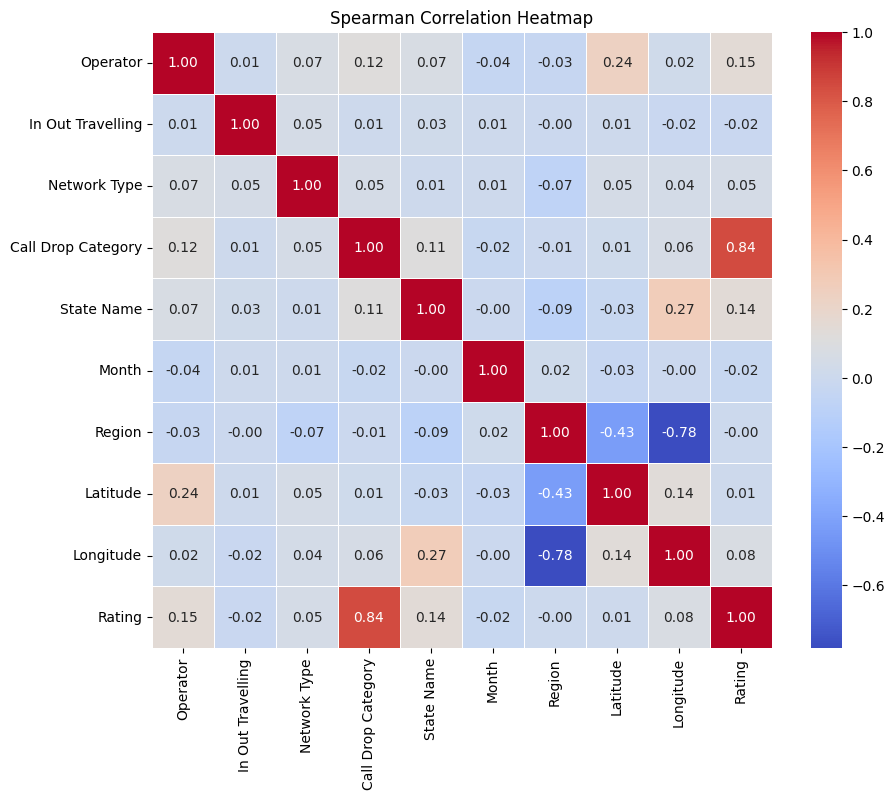

In [31]:
# Correlation Matrix
X['Rating'] = df['Rating']
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

#### Inference 
The correlation analysis of the features with the target variable - Rating, reveals that Call Drop Category has a strong positive correlation, making it the most important feature for prediction,while other show weak correlations, indicating minimal linear relationships with Rating. 

Since there is no significant multicollinearity between independent variables, all features are retained. However, due to the lack of strong linear relationships between the features and the target, Logistic Regression is not the optimal choice for the base model. Instead, more flexible models like Decision Trees or  Random Forests are better suited to capture the complexity of the data and improve predictive accuracy.


### Statistical Test - Predictors(Independent variables) vs Target variable 

#### Chi-Square (χ²) Independence Test - Categorical vs Categorical

Statistical test for between categorical columns and target column

**Null Hypothesis and Alternative Hypothesis**
* Null Hypothesis (H₀): The target variable (Rating) is independent of the independent feature.
* Alternative Hypothesis (H₁): The target variable (Rating) is dependent on the independent feature.


When Null Hypothesis is Rejected:
* Dependence Identified: If the p-value < α (e.g., 0.05), the test suggests a statistically significant relationship between the feature and the target variable.
* Model Relevance: This indicates that the independent feature could provide predictive power for your target variable (Rating), making it relevant to include in your model.

When Null Hypothesis is Not Rejected:
* No Evidence of Dependence: If the p-value ≥ α, the test does not provide evidence of a relationship between the feature and the target variable.
* Possible Irrelevance: The feature may not contribute meaningfully to predicting the target variable and can be considered for exclusion.


In [36]:
# Create a contingency table
for i in df.select_dtypes(include = 'object').columns:
    contingency_table = pd.crosstab(df[i], df['Rating'])
    print(f"\033[1mContingency Table {i}, Rating:\033[0m")
    print(contingency_table)
    # Perform the chi-squared test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Print results
    print("\nChi-Squared Test Results:")
    print(f"Chi-Squared Statistic:{round(chi2_stat,3)}")
    print(f"p-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    print("\nExpected Frequencies:")
    print(expected)
    # Interpret p-value
    alpha = 0.05
    if p_value < alpha:
        print(f"\033[1mConclusion: Reject the null hypothesis. Ratings depend on {i}.\033[0m")
    else:
        print(f"\033[1mConclusion: Fail to reject the null hypothesis. Ratings are independent of {i}.\033[0m")
    print('-------------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------------')

Contingency Table Operator, Rating:
Rating        1     2     3      4      5
Operator                                 
Airtel     9431  3454  5970   8509   9146
BSNL       3615  1720  1653   4174   5915
Idea       3150  1754  1369   3580   3000
MTNL        134    40    38     57   1137
Others       26    19    18      4     49
RJio      12238  6350  9271  16239  25465
Tata        126   156   173     47     96
Vodafone   5016  1723  2694   7756  15405

Chi-Squared Test Results:
Chi-Squared Statistic:8114.759
p-value: 0.0
Degrees of Freedom: 28

Expected Frequencies:
[[ 7214.87233257  3254.13497191  4530.89534141  8632.78208966
  12877.31526444]
 [ 3374.64735205  1522.07238881  2119.25773063  4037.85318392
   6023.16934459]
 [ 2539.92752919  1145.58742246  1595.05882835  3039.08924126
   4533.33697874]
 [  277.84471377   125.31672886   174.48476719   332.44841463
    495.90537556]
 [   22.92317695    10.33907578    14.39561379    27.42817646
     40.91395702]
 [13746.59446921  6200.1476

#### Inference 
* The Chi-Square test results show that all categorical features have rejected the null hypothesis, indicating a significant association with the target variable. This suggests that each feature contributes meaningfully to the target and will be considered for model building.


### Kruskal-Wallis H Test - Categorical vs Numerical 

Statistical test for between numerical columns and target column

Since Latitude and Longitude doesn't follow a normal distribution, the Kruskal-Wallis H Test is used as a non-parametric test to compare the distributions of these numerical features across the different Rating categories. This is especially useful when the assumptions of parametric tests like ANOVA (normality and homogeneity of variance) may not hold.

**Null Hypothesis and Alternative Hypothesis**

Null Hypothesis (H₀): The target variable (Rating) is independent of the independent feature (e.g., Latitude or Longitude). That is, the distribution of the feature does not differ across the different categories of the target variable.

Alternative Hypothesis (H₁): The target variable (Rating) is dependent on the independent feature. That is, the distribution of the feature differs across at least one category of the target variable.

When Null Hypothesis is Rejected:

* Dependence Identified: If the p-value < α 0.05, the test suggests a statistically significant difference in the distribution of the feature (Latitude, Longitude, etc.) across the different categories of Rating. This indicates that the feature is related to the target variable and may contribute valuable information in predicting the target.

* Model Relevance: This suggests that the independent feature could be predictive of the target variable (Rating) and is therefore relevant to be included in the model for further analysis.

When Null Hypothesis is Not Rejected:

* No Evidence of Dependence: If the p-value ≥ α, the test does not provide enough evidence to suggest a relationship between the independent feature and the target variable. In this case, the feature may not show a statistically significant difference across the Rating categories.

* Possible Irrelevance: The feature may not provide meaningful information for predicting the target variable (Rating) and could be considered for exclusion from the model.

In [55]:
# Filtering latitude and longitude by rating levels.
rating1_lat = df[df['Rating'] == 1]['Latitude']
rating2_lat = df[df['Rating'] == 2]['Latitude']
rating3_lat = df[df['Rating'] == 3]['Latitude']
rating4_lat = df[df['Rating'] == 4]['Latitude']
rating5_lat = df[df['Rating'] == 5]['Latitude']
rating1_long = df[df['Rating'] == 1]['Longitude']
rating2_long = df[df['Rating'] == 2]['Longitude']
rating3_long = df[df['Rating'] == 3]['Longitude']
rating4_long = df[df['Rating'] == 4]['Longitude']
rating5_long= df[df['Rating'] == 5]['Longitude']

In [57]:
# Performing Krushkal Wallis H test 
stat_lat , pval_lat = kruskal(rating1_lat,rating2_lat,rating3_lat,rating4_lat, rating5_lat)
stat_long , pval_long = kruskal(rating1_long,rating2_long,rating3_long,rating4_long, rating5_long)

# Interpretation of p-value
if pval_lat < 0.05:
    print("Latitude shows significant difference across Rating categories.")
else:
    print("Latitude does not show significant difference across Rating categories.")

if pval_long < 0.05:
    print("Longitude shows significant difference across Rating categories.")
else:
    print("Longitude does not show significant difference across Rating categories.")

Latitude shows significant difference across Rating categories.
Longitude shows significant difference across Rating categories.


#### Inference 

The Kruskal-Wallis H Test results indicate that all tested numerical features (e.g., Latitude, Longitude) have rejected the null hypothesis, suggesting a significant association between each feature and the target variable (Rating). This means that the distributions of these numerical features differ across the Rating categories, and they are likely to contribute valuable information in predicting the target. As a result, these features will be retained and considered for model building.

### Class Imbalance 

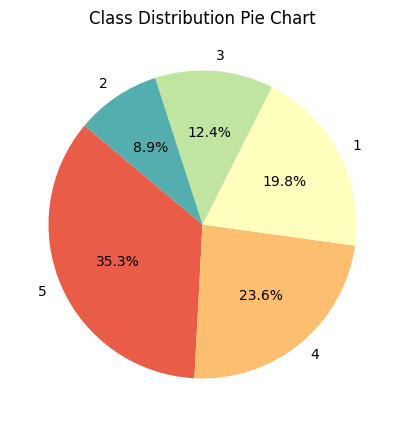

In [61]:
# Count the occurrences of each class
class_counts = df['Rating'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Spectral', len(class_counts)))
plt.title('Class Distribution Pie Chart')
plt.show()

#### Inference
* The majority of the ratings are concentrated in the higher ratings (such as 5, with 35.3% of the total), while ratings like 2 and 3 have lower proportions (8.9% and 12.4%, respectively).
* This imbalance could lead to challenges in model training, as the model may become biased towards predicting the majority classes 
(such as 5).

#### Techniques for Handling Class Imbalance:

Ensemble Methods: 
Techniques like Random Forests, XGBoost, and Gradient Boosting are effective in handling imbalanced datasets as they adjust weights or splitting criteria internally, improving model learning for underrepresented classes without manual intervention.

Cross-Validation: Ensures that each fold in cross-validation reflects the original class distribution, preventing any bias during model evaluation. This method was applied during hyperparameter tuning.

Class Weights: By assigning higher weights to minority classes, the model places more importance on these underrepresented categories, enhancing performance without altering the natural data distribution.

SMOTE: While SMOTE generates synthetic samples for the minority class, it is not used in this case. SMOTE may lead to over-sampling of certain locations or features, especially if duplicates already represent the same rating from the same location, which could distort the data's natural distribution by merely creating copies rather than new, unseen observations.


### Encoding, Splitting the Data, and Conducting Statistical Tests on Train and Test Sets

#### Pre-Modeling Considerations
  
The target column is rating of the call quality, which is a categorical variable with values ranging from 1 to 5. This makes the problem a multi-class classification task. The goal is to build predictive models that can accurately classify the call quality rating based on various input features, such as operator, network type, geographic location, and other related factors. 

Several classification algorithms, including decision trees, random forests, will be considered for model building. The model's performance will be evaluated using appropriate metrics, such as accuracy, precision, recall, and F1-score, to ensure robust predictions and handle any class imbalance.

The dataset was split into training and testing sets with a 70-30 ratio for model building. To ensure that the training and testing data were representative of the same underlying distribution, we performed a series of tests. These included a Chi-Square test for categorical columns and a Kolmogorov-Smirnov test for numerical columns to compare the distributions of features between the two sets. This step was crucial to confirm that the model would generalize well and perform consistently on unseen data.


#### Data Distribution Consistency: Training vs. Testing

The dataset was split into training and testing sets with a 70-30 ratio for model building. To ensure the training and testing data were representative of the same underlying distribution, we performed a series of tests to check for any significant differences. This step was crucial to confirm that the model would generalize well and perform consistently on unseen data.

Tests Performed:

1.	Chi-Square Test for Categorical Variables:

This test was applied to features such as Operator, In/Out/Travelling, Network Type, Call Drop Category, State Name, Month, and Region to assess the similarity in their distributions across the training and test sets.
The p-values from the Chi-Square test for all these features were greater than 0.05, indicating that there were no significant differences in the distributions of these categorical variables between the two datasets.

2.	Kolmogorov-Smirnov (KS) Test for Continuous Variables:
  
The KS test was applied to Rating, Latitude, and Longitude to compare their distributions between the training and test sets.
For all these continuous variables, the p-values were also greater than 0.05, suggesting that the distributions in both datasets were similar.

Conclusion:

The results of both the Chi-Square test for categorical variables and the KS test for continuous variables show that the distributions in the train and test datasets are similar. With high p-values across all tests, there is no indication of significant discrepancies. This consistency ensures that the training and testing sets are representative of the same underlying data distribution. As a result, the model can be trained and tested confidently, with reduced risks of bias or performance issues due to data distribution shifts.


In [71]:
# Spliting the dataset into train and test
train_data,test_data=train_test_split(df,test_size=0.3,random_state=11)


Distribution of Operator in train data:
Operator
RJio        0.408766
Airtel      0.212383
Vodafone    0.191580
BSNL        0.099547
Idea        0.075146
MTNL        0.008326
Tata        0.003573
Others      0.000678
Name: proportion, dtype: float64

Distribution of Operator in test data:
Operator
RJio        0.404463
Airtel      0.217315
Vodafone    0.189394
BSNL        0.101160
Idea        0.075621
MTNL        0.008025
Tata        0.003339
Others      0.000683
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for Operator: p-value = 0.28246475798903026
The distributions of Operator in the train and test data are similar.


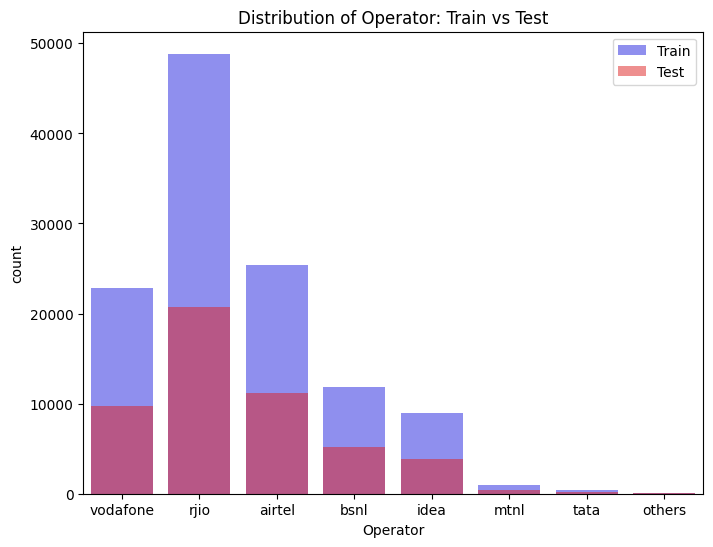


Distribution of In Out Travelling in train data:
In Out Travelling
Indoor        0.684814
Outdoor       0.190802
Travelling    0.124384
Name: proportion, dtype: float64

Distribution of In Out Travelling in test data:
In Out Travelling
Indoor        0.683068
Outdoor       0.191542
Travelling    0.125391
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for In Out Travelling: p-value = 0.28246475798903026
The distributions of In Out Travelling in the train and test data are similar.


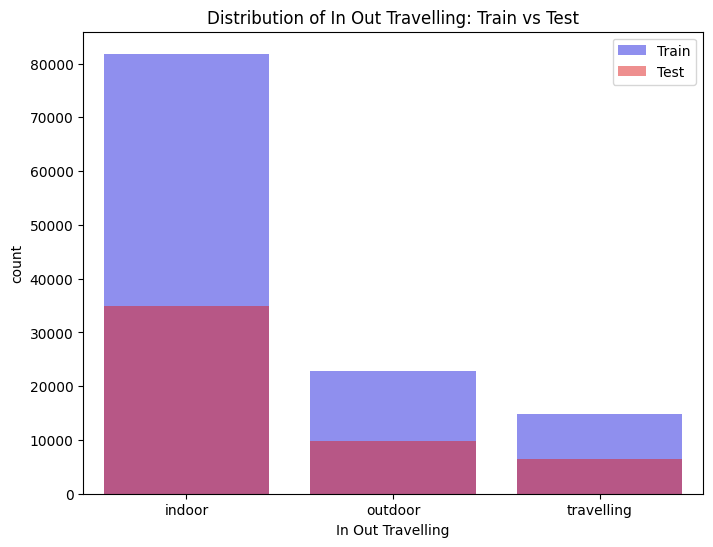


Distribution of Network Type in train data:
Network Type
4G         0.570004
3G         0.216299
Unknown    0.161706
2G         0.051991
Name: proportion, dtype: float64

Distribution of Network Type in test data:
Network Type
4G         0.571794
3G         0.217217
Unknown    0.159540
2G         0.051449
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for Network Type: p-value = 0.28246475798903026
The distributions of Network Type in the train and test data are similar.


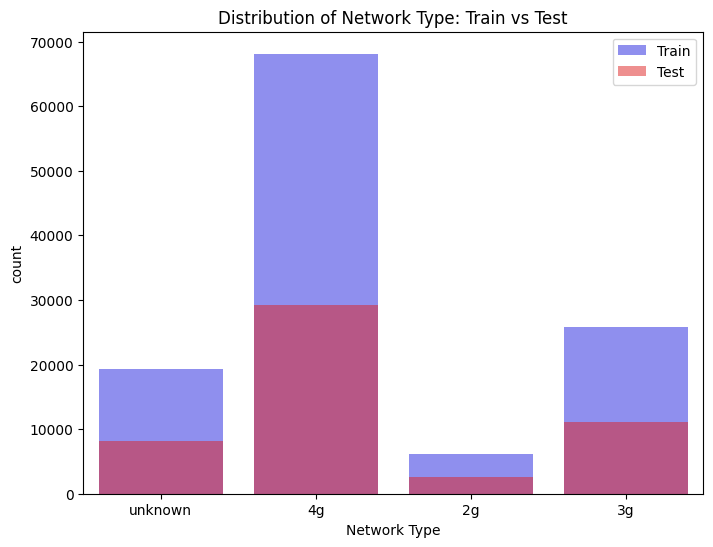


Distribution of Call Drop Category in train data:
Call Drop Category
Satisfactory          0.666086
Poor Voice Quality    0.252835
Call Dropped          0.081079
Name: proportion, dtype: float64

Distribution of Call Drop Category in test data:
Call Drop Category
Satisfactory          0.661141
Poor Voice Quality    0.254998
Call Dropped          0.083861
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for Call Drop Category: p-value = 0.28246475798903026
The distributions of Call Drop Category in the train and test data are similar.


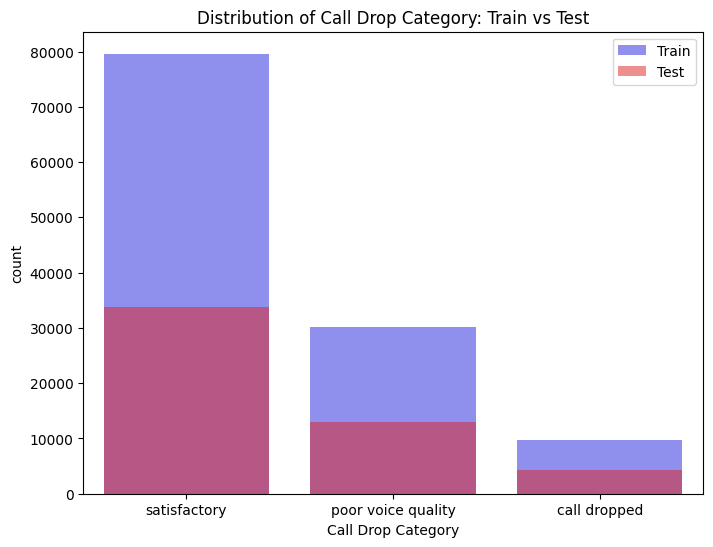


Distribution of State Name in train data:
State Name
Maharashtra                    0.267379
West Bengal                    0.072485
Rajasthan                      0.071188
Uttar Pradesh                  0.070886
Gujarat                        0.068050
Tamil Nadu                     0.062451
Karnataka                      0.059539
Delhi                          0.057079
Telangana                      0.055665
Odisha                         0.047339
Kerala                         0.033707
Haryana                        0.029648
Bihar                          0.026318
Madhya Pradesh                 0.018000
Andhra Pradesh                 0.016050
Uttarakhand                    0.010000
Chhattisgarh                   0.007556
Jharkhand                      0.006025
Punjab                         0.004862
Meghalaya                      0.003406
Assam                          0.003222
Chandigarh                     0.003121
Goa                            0.001774
Dadra and Nagar Haveli    

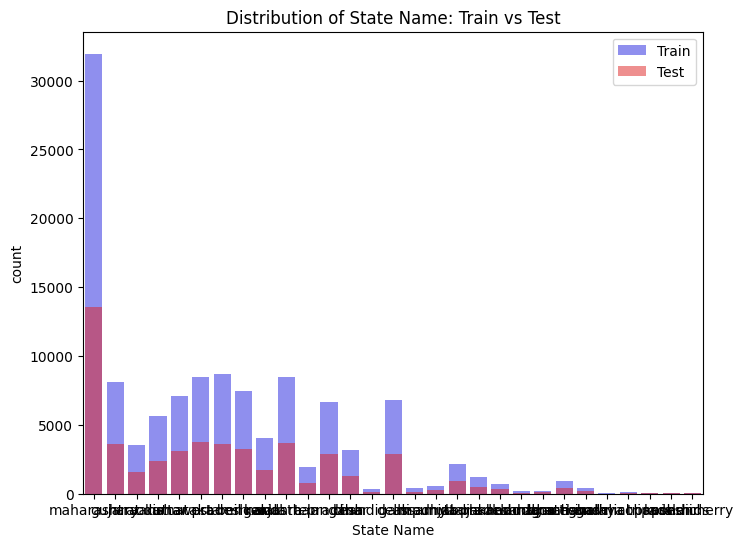


Distribution of Month in train data:
Month
July         0.371378
September    0.366256
August       0.262366
Name: proportion, dtype: float64

Distribution of Month in test data:
Month
July         0.376172
September    0.364769
August       0.259060
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for Month: p-value = 0.28246475798903026
The distributions of Month in the train and test data are similar.


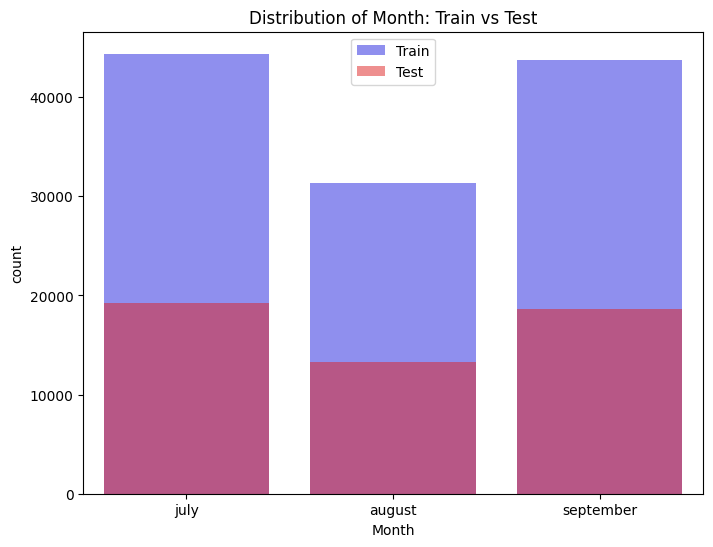


Distribution of Region in train data:
Region
West         0.409971
South        0.227998
North        0.177045
East         0.152409
Central      0.025556
Northeast    0.007021
Name: proportion, dtype: float64

Distribution of Region in test data:
Region
West         0.411161
South        0.228776
North        0.177952
East         0.149153
Central      0.026027
Northeast    0.006931
Name: proportion, dtype: float64

Contingency Table (Train vs Test):
 Dataset    Test  Train
Operator              
airtel    11130  25380
bsnl       5181  11896
idea       3873   8980
mtnl        411    995
others       35     81
rjio      20715  48848
tata        171    427
vodafone   9700  22894

Chi-Square Statistic: 8.602541643968376, p-value: 0.28246475798903026

Chi-Square test for Region: p-value = 0.28246475798903026
The distributions of Region in the train and test data are similar.


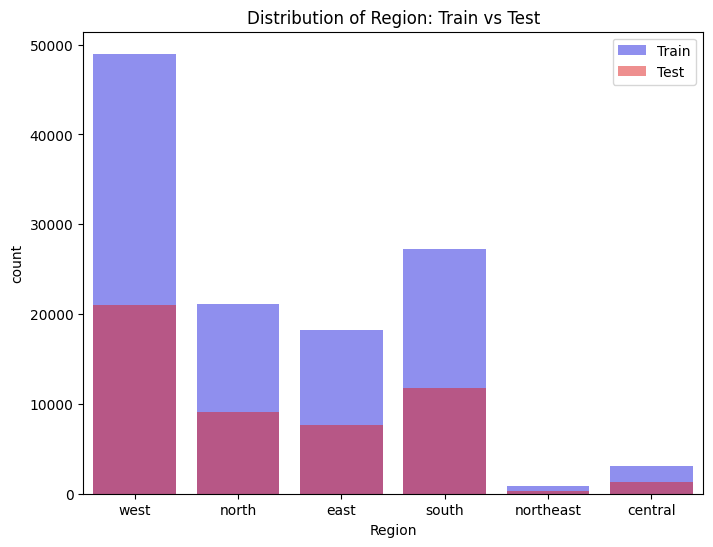


Rating statistics in train data:
count    119501.000000
mean          3.462766
std           1.520409
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64
Rating statistics in test data:
count    51216.000000
mean         3.445232
std          1.526827
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

KS test for Rating: p-value = 0.2429432659855495
The distributions of Rating in the train and test data are similar.


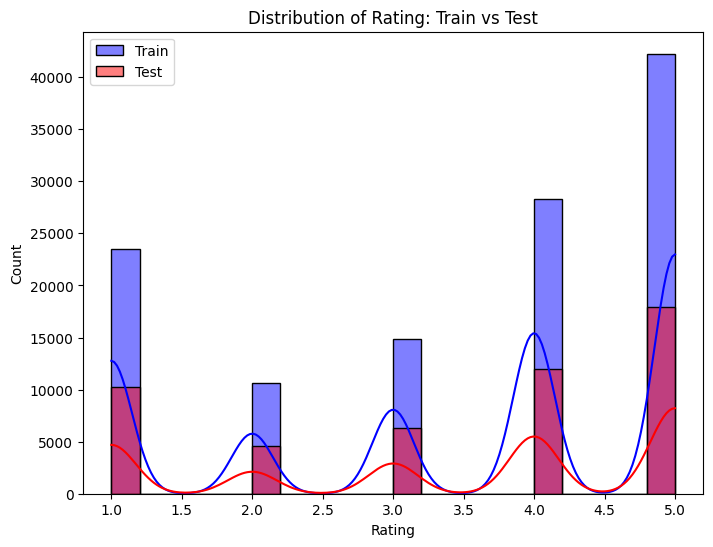


Latitude statistics in train data:
count    119501.000000
mean         21.010032
std           5.406598
min           8.084712
25%          18.452021
50%          20.310055
75%          25.788770
max          32.987526
Name: Latitude, dtype: float64
Latitude statistics in test data:
count    51216.000000
mean        21.012856
std          5.419210
min          8.197511
25%         18.447558
50%         20.310055
75%         26.072535
max         32.761533
Name: Latitude, dtype: float64

KS test for Latitude: p-value = 0.8543857282963234
The distributions of Latitude in the train and test data are similar.


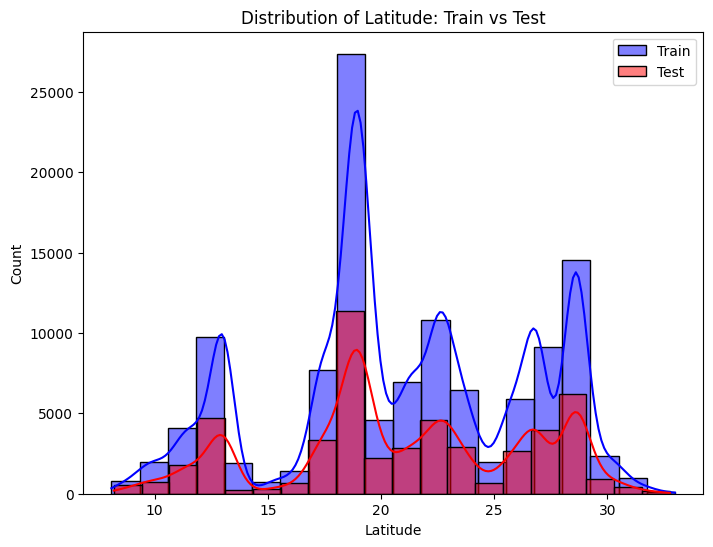


Longitude statistics in train data:
count    119501.000000
mean         77.779108
std           4.799246
min          68.965040
25%          73.794660
50%          77.159650
75%          79.096455
max          95.629638
Name: Longitude, dtype: float64
Longitude statistics in test data:
count    51216.000000
mean        77.742595
std          4.773770
min         69.017391
25%         73.794660
50%         77.149773
75%         79.078803
max         94.309320
Name: Longitude, dtype: float64

KS test for Longitude: p-value = 0.45009849821012893
The distributions of Longitude in the train and test data are similar.


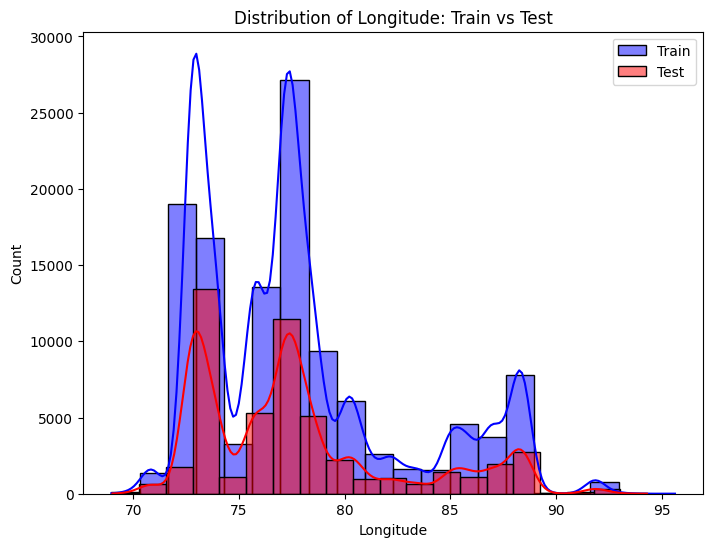

In [73]:
def check_categorical_representation(train_data, test_data, categorical_columns):
    """Check if the categorical columns in train and test data have similar distributions."""
    
    for column in categorical_columns:
        # Check frequency distributions
        train_freq = train_data[column].value_counts(normalize=True)
        test_freq = test_data[column].value_counts(normalize=True)
        
        print(f"\nDistribution of {column} in train data:\n{train_freq}")
        print(f"\nDistribution of {column} in test data:\n{test_freq}")
        
        # Chi-Square test for categorical distribution similarity
        train_data[column] = train_data[column].str.strip().str.lower()
        test_data[column] = test_data[column].str.strip().str.lower()

        # Step 1: Create combined DataFrame with train and test data
        train_data['Dataset'] = 'Train'
        test_data['Dataset'] = 'Test'

        combined_data = pd.concat([train_data, test_data], axis=0)

        # Step 2: Create contingency table comparing 'Operator' between 'Train' and 'Test' datasets
        contingency_table = pd.crosstab(combined_data['Operator'], combined_data['Dataset'])
        print("\nContingency Table (Train vs Test):\n", contingency_table)

        # Step 3: Perform Chi-Square test
        if contingency_table.size > 0:
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
            print(f"\nChi-Square Statistic: {chi2_stat}, p-value: {p_value}")
        else:
            print("Contingency table is empty. Cannot perform Chi-Square test.")
        
        print(f"\nChi-Square test for {column}: p-value = {p_value}")
        if p_value < 0.05:
            print(f"The distributions of {column} in the train and test data are significantly different.")
        else:
            print(f"The distributions of {column} in the train and test data are similar.")
        
        # Visual comparison of distributions
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=train_data, color='blue', label="Train", alpha=0.5)
        sns.countplot(x=column, data=test_data, color='red', label="Test", alpha=0.5)
        plt.title(f"Distribution of {column}: Train vs Test")
        plt.legend()
        plt.show()

def check_numerical_representation(train_data, test_data, numerical_columns):
    """Check if the numerical columns in train and test data have similar distributions."""
    
    for column in numerical_columns:
        # Check basic statistics
        train_stats = train_data[column].describe()
        test_stats = test_data[column].describe()
        
        print(f"\n{column} statistics in train data:\n{train_stats}")
        print(f"{column} statistics in test data:\n{test_stats}")
        
        # Kolmogorov-Smirnov test for numerical distribution similarity
        statistic, p_value = ks_2samp(train_data[column], test_data[column])
        
        print(f"\nKS test for {column}: p-value = {p_value}")
        if p_value < 0.05:
            print(f"The distributions of {column} in the train and test data are significantly different.")
        else:
            print(f"The distributions of {column} in the train and test data are similar.")
        
        # Visual comparison of distributions
        plt.figure(figsize=(8, 6))
        sns.histplot(train_data[column], color='blue', label="Train", kde=True, bins=20, alpha=0.5)
        sns.histplot(test_data[column], color='red', label="Test", kde=True, bins=20, alpha=0.5)
        plt.title(f"Distribution of {column}: Train vs Test")
        plt.legend()
        plt.show()

def check_train_test_representation(train_data, test_data, categorical_columns, numerical_columns):
    """Run checks for both categorical and numerical columns to compare train and test data."""
    
    # Check categorical columns
    check_categorical_representation(train_data, test_data, categorical_columns)
    
    # Check numerical columns
    check_numerical_representation(train_data, test_data, numerical_columns)

# Sample data (replace this with your actual train and test data)

# Define categorical and numerical columns in your dataset
categorical_columns = df.select_dtypes('O')
numerical_columns = df.select_dtypes(np.number)

# Run the train-test representation check
check_train_test_representation(train_data, test_data, categorical_columns, numerical_columns) 

In [74]:
# Accessing Variables from Train and Test Sets
X_train=train_data.drop(['Dataset','Rating'],axis=1)
X_test=test_data.drop(['Dataset','Rating'],axis=1) 

In [75]:
# Accessing Variables from Train and Test Sets
y_train=train_data['Rating'] 
y_test=test_data['Rating'] 

In [76]:
# Label Encoding for Categorical Columns
le=LabelEncoder()
for col in X_train.select_dtypes(exclude = np.number).columns:
    X_train[col] = le.fit_transform(X_train[col])
for col in X_test.select_dtypes(exclude = np.number).columns:
    X_test[col] = le.fit_transform(X_test[col])

## Model Building 

#### Baseline Model Performance: Evaluation with Default Parameters
* Decision Tree Classifier – Base Model
* k-Nearest Neighbors (k-NN) Classifier 
* Naïve Bayes Classifier
* Random Forest Classifier 
* Gradient Boosting Classifier 
* Adaptive Boosting (AdaBoost) Classifier 
* Extreme Gradient Boosting (XGBoost) Classifier 


### Decision Tree Classifier

In [139]:
dt = DecisionTreeClassifier(random_state = 42)

dt.fit(X_train,y_train)

# Predictions on training data
y_train_pred_dt = dt.predict(X_train)

# Predictions on testing data
y_test_pred_dt = dt.predict(X_test)


print('***************************************')
print("\033[1mDecision Tree Classifier:\033[0m")
print('***************************************')

# Evaluate train model
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_dt), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_dt))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_dt))

print('-' * 80)
print('-' * 80)

# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_dt), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_dt))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

***************************************
Decision Tree Classifier:
***************************************

Evaluating performance on training data

Accuracy: 0.9633

Confusion Matrix:
[[23155   259    58     0     0]
 [  964  9527   109     0     0]
 [  233   243 13752   519    87]
 [    0     0   357 27465   523]
 [    0     0    51   985 41214]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.99      0.97     23472
           2       0.95      0.90      0.92     10600
           3       0.96      0.93      0.94     14834
           4       0.95      0.97      0.96     28345
           5       0.99      0.98      0.98     42250

    accuracy                           0.96    119501
   macro avg       0.96      0.95      0.95    119501
weighted avg       0.96      0.96      0.96    119501

--------------------------------------------------------------------------------
-----------------------------------------------

#### Decision Tree Model Summary 
* Reason for choosing : Non-linear relationships in data (ruled out logistic regression).
Handles both categorical and numerical features.
Simple and interpretable, making it a good baseline model.
* Training Performance	Accuracy = 96.33% , Weighted f1-score = 96% 
* Testing Performance	Accuracy = 83.76 % , Weighted f1-score = 84% 

* Overfitting Evidence : High training accuracy (0.96) but significantly lower test accuracy (0.84), indicating overfitting.
Reasons for Poor Test Performance
* Reasons for Poor Test Performance
1. Lack of Depth Control: Without limiting max_depth, the model grows too complex and memorizes training data rather than generalizing.
2. Imbalance in Class Distribution: The model struggles with classifying ratings 1 and 2 due to insufficient emphasis on minority classes.
3. Greedy Splitting: Decision Trees split on the best feature at each node but may fail to find globally optimal splits.
* Conclusion : Implement hyperparameter tuning (e.g., limit max_depth, increase min_samples_leaf) to reduce overfitting.
Use class weights to prioritize ratings 1 and 2.
Consider ensemble methods (e.g., Random Forest, Gradient Boosting) for better generalization.



### k-Nearest Neighbors (k-NN) Classifier 

In [141]:
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train)
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

# Evaluate train model
print('***************************')
print("\033[1mK-Nearest Neighbors (KNN):\033[0m")
print('***************************')
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_knn), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_knn))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_knn))
print('-' * 80)
print('-' * 80)

# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_knn), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_knn))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_knn))

***************************
K-Nearest Neighbors (KNN):
***************************

Evaluating performance on training data

Accuracy: 0.8724

Confusion Matrix:
[[21559  1302   463    61    87]
 [ 2438  7523   562    37    40]
 [ 1143   615 11206  1318   552]
 [   34    26  1019 24722  2544]
 [   31     6   539  2426 39248]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.92      0.89     23472
           2       0.79      0.71      0.75     10600
           3       0.81      0.76      0.78     14834
           4       0.87      0.87      0.87     28345
           5       0.92      0.93      0.93     42250

    accuracy                           0.87    119501
   macro avg       0.85      0.84      0.84    119501
weighted avg       0.87      0.87      0.87    119501

--------------------------------------------------------------------------------
----------------------------------------------------------------------

#### k-NN Model Summary 

* Reason for choosing : k-NN’s non-parametric nature allows for quick evaluation without making assumptions about data distribution. 
It also enables fast prototyping and computational efficiency, making it useful for understanding the data and its characteristics early in the modelling process. 
Even if not used in the final model, k-NN helps establish baseline metrics for further comparison.
* Training Performance	Accuracy = 87% , Weighted f1-score = 87% 
* Testing Performance	Accuracy = 83 % , Weighted f1-score = 83% 

* Limitations of k-NN for This Dataset : 
Categorical Features: k-NN is not well-suited for datasets with many categorical features like operator, in/out/travel, and network type. Distance metrics used in k-NN are more effective for numeric and continuous data, leading to reduced model efficacy.  
Lazy Learning: k-NN stores all training data and makes predictions at runtime, making it computationally expensive and slower on large datasets. This is impractical for real-time churn prediction scenarios.
Fixed k Value: The default k=5 may not be optimal for this dataset, as it may not balance bias and variance effectively.


* Conclusion : Given the high proportion of categorical features, the inefficiency of k-NN’s lazy learning approach, and its reliance on distance-based metrics that are less effective for mixed-type data, k-NN is not a suitable model for this classification problem. It will not be considered for further optimization.

### Naive Bayes Classifier

In [143]:
nb = GaussianNB()

nb.fit(X_train, y_train)

y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb = nb.predict(X_test)

# Evaluate train model
print('***************************')
print("\033[1mNaive Bayes Classifier:\033[0m")
print('***************************')
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_nb), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_nb))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_nb))
print('-' * 80)
print('-' * 80)

# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_nb), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_nb))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_nb))

***************************
Naive Bayes Classifier:
***************************

Evaluating performance on training data

Accuracy: 0.5663

Confusion Matrix:
[[19350  4081    41     0     0]
 [ 6485  4086    29     0     0]
 [ 4220  1601    10  4295  4708]
 [    0     0     0 14467 13878]
 [    0     0     0 12484 29766]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.82      0.72     23472
           2       0.42      0.39      0.40     10600
           3       0.12      0.00      0.00     14834
           4       0.46      0.51      0.49     28345
           5       0.62      0.70      0.66     42250

    accuracy                           0.57    119501
   macro avg       0.45      0.49      0.45    119501
weighted avg       0.51      0.57      0.53    119501

--------------------------------------------------------------------------------
-------------------------------------------------------------------------

#### Naive Bayes Model Summary 

* Reason for choosing 	Naive Bayes was selected to quickly check model performance with simpler assumptions (Gaussian distribution for features) and a relatively straightforward approach.
* Training Performance	Accuracy = 57% , Weighted f1-score = 53% 
* Testing Performance	Accuracy = 57% , Weighted f1-score = 52% 

* Reasons for Poor Test Performance : The model's performance is significantly low, especially for class 3, which had very poor precision and recall. This suggests that Gaussian Naive Bayes struggles with the data's feature distributions and class imbalance. Additionally, its assumptions about feature independence and Gaussian distributions do not align well with the underlying complexity of the data, leading to poor overall classification results.
The model does not generalize well to unseen data as seen by the very similar performance on both training and test sets. There is no significant overfitting, but the model's predictive power is weak overall.
* Conclusion : It should be excluded from further consideration for this dataset, as more complex models like XGBoost and Gradient Boosting can show better performance.


### Random Forest Classifier

In [145]:
rf = RandomForestClassifier(n_estimators= 100,random_state = 42)

rf.fit(X_train,y_train)

# Predictions on training data
y_train_pred_rf = rf.predict(X_train)

# Predictions on testing data
y_test_pred_rf = rf.predict(X_test)



print('***************************************')
print("\033[1mRandom Forest Classifier:\033[0m")
print('***************************************')

# Evaluate train model
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_rf), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_rf))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_rf))

print('-' * 80)
print('-' * 80)

# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_rf), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

***************************************
Random Forest Classifier:
***************************************

Evaluating performance on training data

Accuracy: 0.9633

Confusion Matrix:
[[22972   404    96     0     0]
 [  814  9616   170     0     0]
 [  187   196 13728   618   105]
 [    0     0   256 27387   702]
 [    0     0    31   812 41407]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97     23472
           2       0.94      0.91      0.92     10600
           3       0.96      0.93      0.94     14834
           4       0.95      0.97      0.96     28345
           5       0.98      0.98      0.98     42250

    accuracy                           0.96    119501
   macro avg       0.96      0.95      0.95    119501
weighted avg       0.96      0.96      0.96    119501

--------------------------------------------------------------------------------
-----------------------------------------------

#### Random Forest Model Summary 

* Reason for choosing : Random Forest is chosen due to its ability to handle high-dimensional data, capture complex relationships, and provide good generalization capabilities for classification tasks.
Ensemble method reduces overfitting compared to a single decision tree, offering better performance overall.
Random Forest is less sensitive to noise and irrelevant features compared to simpler models like decision trees.

* Training Performance	Accuracy = 96% , Weighted f1-score = 96% 
* Testing Performance	Accuracy = 85 % , Weighted f1-score = 85% 

* Reasons for Poor Test Performance :
1. Overfitting: Random Forest tends to perform very well on the training set but can overfit if the trees are too deep or the model is too complex.
2. Imbalance in Class Distribution: The model struggles with minority classes (ratings 1 and 2) as they are underrepresented in the dataset.
* Conclusion : While Random Forest provides strong performance on training data, it shows overfitting when applied to the test set. The model may need hyperparameter tuning (e.g., limiting depth, using class weights) to improve generalization and performance on minority classes.


### Gradient Boosting Classifier

In [147]:
gbc = GradientBoostingClassifier(n_estimators= 100,random_state = 42)

gbc.fit(X_train, y_train)


# Predictions on training data
y_train_pred_gbc = gbc.predict(X_train)

# Predictions on testing data
y_test_pred_gbc = gbc.predict(X_test)

print('*******************************************')
print("\033[1mGradient Boosting Classifier:\033[0m")
print('*******************************************')

# Evaluate train model
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_gbc), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_gbc))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_gbc))

print('-' * 80)
print('-' * 80)

# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_gbc), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_gbc))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_gbc))

*******************************************
Gradient Boosting Classifier:
*******************************************

Evaluating performance on training data

Accuracy: 0.7398

Confusion Matrix:
[[21954  1196   322     0     0]
 [ 5326  4979   295     0     0]
 [ 3614   510  4694  3162  2854]
 [    0     0   234 20294  7817]
 [    0     0   170  5589 36491]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.94      0.81     23472
           2       0.74      0.47      0.58     10600
           3       0.82      0.32      0.46     14834
           4       0.70      0.72      0.71     28345
           5       0.77      0.86      0.82     42250

    accuracy                           0.74    119501
   macro avg       0.75      0.66      0.67    119501
weighted avg       0.75      0.74      0.72    119501

--------------------------------------------------------------------------------
-----------------------------------

#### Gradient Boosting Model Summary 
* Reason for choosing : Gradient Boosting was chosen because it is a powerful ensemble method known for handling complex data patterns and interactions.
It typically performs better than single decision trees by combining weak learners and is less prone to overfitting compared to a single model.

* Training Performance	Accuracy = 73 % , Weighted f1-score = 72 %
* Testing Performance	Accuracy = 73 % , Weighted f1-score = 72%

* Reasons for Poor Test Performance :
1. Inadequate recall for minority classes: The model struggles with ratings 2 and 3 due to their lower occurrence in the dataset, which lowers the model’s performance for these ratings.
2. Class Imbalance: The model might underperform on classes with lower support (ratings 1 and 2), as it does not prioritize those classes well.
3. Training Data Distribution: Gradient Boosting focuses on optimizing the errors made by previous estimators, which can sometimes lead to a bias against less frequent classes or classes with higher misclassification errors.

* Conclusion : Gradient Boosting performs reasonably well but struggles with class imbalance and lower-represented classes, like ratings 1 and 2, impacting its overall performance. 
Hyperparameter tuning (e.g., adjusting the number of estimators, max depth, and class weights) could improve results.


### AdaBoost Classifier

In [149]:
ada = AdaBoostClassifier(estimator= dt,random_state=42)

ada.fit(X_train, y_train)

# Predict on training data
y_train_pred_ada = ada.predict(X_train)
# Predict on testing data
y_test_pred_ada = ada.predict(X_test)

print("**********************************")
print("\033[1mAdaBoost Classifier:\033[0m")
print("**********************************")

# Evaluate the train model
print("\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_ada), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_ada))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_ada))

print('-' * 80)
print('-' * 80)

# Evaluate the test model
print("\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_ada), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_ada))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_ada))

**********************************
AdaBoost Classifier:
**********************************
Evaluating performance on training data

Accuracy: 0.9633

Confusion Matrix:
[[22837   577    58     0     0]
 [  646  9844   110     0     0]
 [  214   261 13558   708    93]
 [    0     0   168 27569   608]
 [    0     0    39   906 41305]]

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.97     23472
           2       0.92      0.93      0.93     10600
           3       0.97      0.91      0.94     14834
           4       0.94      0.97      0.96     28345
           5       0.98      0.98      0.98     42250

    accuracy                           0.96    119501
   macro avg       0.96      0.95      0.95    119501
weighted avg       0.96      0.96      0.96    119501

--------------------------------------------------------------------------------
------------------------------------------------------------------------

#### AdaBoost Model Summary

* Reason for choosing : AdaBoost was chosen for its ability to boost weak classifiers and improve performance iteratively by focusing on errors made by previous models.
It is effective for classification tasks with complex relationships between features and the target variable.

* Training Performance	Accuracy = 96% , Weighted f1-score = 96% 
* Testing Performance	Accuracy = 84 % , Weighted f1-score = 84% 

* Reasons for Poor Test Performance : High Complexity of the Model: AdaBoost is sensitive to noise and outliers, and may overfit on training data if not properly tuned.Inadequate Regularization: Default parameters do not include sufficient regularization to prevent overfitting, especially with a large number of estimators.
* Conclusion : Despite the training accuracy being high, the model struggles to generalize well to the test data, indicating overfitting. Given this issue, and the fact that other models such as Gradient Boosting and XGBoost have provided better performance in terms of accuracy and generalization, this model is not suitable for further tuning or deployment.


### XGBoost Classifier

In [151]:
rating_encoded = {1:0,2:1,3:2,4:3,5:4}
ytrain_for_xgbc = y_train.map(rating_encoded)
ytest_for_xgbc = y_test.map(rating_encoded)

xgbc = XGBClassifier(objective='multi:softmax',num_class = 5,eval_metric='mlogloss',random_state = 42)

xgbc.fit(X_train,ytrain_for_xgbc)

# Predictions on training data
y_train_pred_xgbc = xgbc.predict(X_train)

# Predictions on testing data
y_test_pred_xgbc = xgbc.predict(X_test)



print('*********************************')
print("\033[1mXGBoost Classifier:\033[0m")
print('*********************************')

# Evaluate train model
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(ytrain_for_xgbc, y_train_pred_xgbc), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(ytrain_for_xgbc, y_train_pred_xgbc))
print("\nTraining Classification Report:")
print(classification_report(ytrain_for_xgbc, y_train_pred_xgbc))

print('-' * 80)
print('-' * 80)


# Evaluate test model
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(ytest_for_xgbc, y_test_pred_xgbc), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(ytest_for_xgbc, y_test_pred_xgbc))
print("\nTesting Classification Report:")
print(classification_report(ytest_for_xgbc, y_test_pred_xgbc))

*********************************
XGBoost Classifier:
*********************************

Evaluating performance on training data

Accuracy: 0.8427

Confusion Matrix:
[[21827  1229   416     0     0]
 [ 3199  6931   470     0     0]
 [ 1795   626  9192  1984  1237]
 [    0     0   484 24107  3754]
 [    0     0   308  3301 38641]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87     23472
           1       0.79      0.65      0.72     10600
           2       0.85      0.62      0.72     14834
           3       0.82      0.85      0.84     28345
           4       0.89      0.91      0.90     42250

    accuracy                           0.84    119501
   macro avg       0.83      0.79      0.81    119501
weighted avg       0.84      0.84      0.84    119501

--------------------------------------------------------------------------------
-----------------------------------------------------------------

#### XGBoost Model Summary 

* Reason for choosing :   	
XGBoost was chosen for its strong performance with imbalanced datasets, ability to handle large datasets, and flexibility to tune various parameters for improvement.
XGBoost has performed well in classification tasks with complex patterns.

* Training Performance	Accuracy = 84% , Weighted f1-score = 84%

* Testing Performance	Accuracy = 84% , Weighted f1-score = 84%

* Reasons for Performance : The model is performing well, with a good balance between precision and recall for most categories.
Accuracy Difference: The small difference between training (0.8427) and test accuracy (0.822) indicates that the model is not overfitting and is generalizing reasonably well.
Minor Drop in Accuracy: The drop in accuracy is likely due to the inherent difficulty of classifying the more imbalanced categories (low ratings 1 and 2), but the model still performs better than simpler models like AdaBoost.
Overall, the precision, recall, and F1-score for the XGBoost model are better than the other models tested.The model shows a good balance between precision and recall, especially for the low and high ratings, while avoiding overfitting, as evidenced by the minimal drop in accuracy between training and test data. This indicates strong generalization performance on unseen data.

* Conclusion : XGBoost is the chosen model due to its better generalization ability, higher overall accuracy, and strong performance in handling complex data relationships. This model will be a good candidate for further optimization through hyperparameter tuning and class weights.


In [178]:
Models_Accuracy_Comparison = pd.DataFrame(columns=["Model", "Train Accuracy", "Test Accuracy"])

models = ['Decision Tree Classifier','k-NN Classifier','Naive Bayes Classifier','Random Forest Classifier','Gradient Boosting Classifier','AdaBoost Classifier','XGBoost Classifier']
Train_accuracy = [round(accuracy_score(y_train, y_train_pred_dt)*100, 2),
                  round(accuracy_score(y_train, y_train_pred_knn)*100, 2),
                  round(accuracy_score(y_train, y_train_pred_nb)*100, 2),
                  round(accuracy_score(y_train, y_train_pred_rf)*100, 2),
                 round(accuracy_score(y_train, y_train_pred_gbc)*100, 2),
                 round(accuracy_score(y_train, y_train_pred_ada)*100, 2),
                  round(accuracy_score(ytrain_for_xgbc, y_train_pred_xgbc)*100, 2)]

Test_accuracy = [round(accuracy_score(y_test, y_test_pred_dt)*100, 2),
                 round(accuracy_score(y_test, y_test_pred_knn)*100, 2),
                 round(accuracy_score(y_test, y_test_pred_nb)*100, 2),
                  round(accuracy_score(y_test, y_test_pred_rf)*100, 2),
                round(accuracy_score(y_test, y_test_pred_gbc)*100, 2),
                round(accuracy_score(y_test, y_test_pred_ada)*100, 2),
                round(accuracy_score(ytest_for_xgbc, y_test_pred_xgbc)*100, 2)]

Models_Accuracy_Comparison['Model'] = models
Models_Accuracy_Comparison['Train Accuracy'] = Train_accuracy
Models_Accuracy_Comparison['Test Accuracy'] = Test_accuracy
Models_Accuracy_Comparison['Diff_%'] = Models_Accuracy_Comparison['Train Accuracy'] - Models_Accuracy_Comparison['Test Accuracy']
Models_Accuracy_Comparison

,Model,Train Accuracy,Test Accuracy,Diff_%
0,Decision Tree Classifier,96.33,83.76,12.57
1,k-NN Classifier,87.24,82.79,4.45
2,Naive Bayes Classifier,56.63,56.62,0.01
3,Random Forest Classifier,96.33,85.41,10.92
4,Gradient Boosting Classifier,73.98,73.36,0.62
5,AdaBoost Classifier,96.33,83.99,12.34
6,XGBoost Classifier,84.27,82.20,2.07


#### Overall – Model Summary of all the ML algorithms – with default parameters  

XGBoost appears to be the best overall model here, as its test accuracy is competitive, and it maintains a low difference between train and test accuracy (2.07%). Additionally, XGBoost shows solid overall precision, recall, and F1-score, which makes it suitable for the dataset at hand.

Hyperparameter Tuning & Overfitting:
Models with a significant gap between training and test accuracy, such as Decision Tree and AdaBoost, may be overfitting to the training data. These models should be avoided in this case, as they are prone to poor generalization on unseen data despite yielding strong performance on the training set.
A difference less than 10% is generally a good indicator that the model isn't overfitting much. If the train accuracy is much higher than test accuracy, there might still be room for model regularization (for example, adjusting the learning rate, increasing or decreasing the number of estimators in Random Forest, Gradient Boosting, or XGBoost).

Since the XGBoost classifier has a low gap between train and test accuracy, it appears stable and could benefit from hyperparameter tuning without significant overfitting. Key areas to focus on during hyperparameter tuning would include:
Learning rate, Number of estimators, Maximum depth of trees, Regularization parameters (e.g., gamma, lambda, and alpha).




## Hyperparameter Tuning - Class Weights

Hyperparameter tuning with class weights was performed for three classification models—Random Forest Classifier, Gradient Boosting Classifier, and XGBoost Classifier. RandomizedSearchCV was employed to identify the optimal hyperparameters for each model, ensuring better handling of class imbalance through the use of class weights.

### Random Forest Classifier - Hyperparameter Tuning - Class Weights

In [281]:
rf_ht_cw = RandomForestClassifier(class_weight= 'balanced',random_state=42,oob_score = True)  

param_grid_rf_cw = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 20, 30],   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2']}  # Number of features to consider for split

random_search_rf_cw = RandomizedSearchCV(estimator=rf_ht_cw, param_distributions=param_grid_rf_cw, 
                           scoring='accuracy', cv=5, verbose=0, n_jobs=-1)

random_search_rf_cw.fit(X_train, y_train)

best_rf_model_cw = random_search_rf_cw.best_estimator_

y_train_pred_rf_ht_cw = best_rf_model_cw.predict(X_train)
y_test_pred_rf_ht_cw = best_rf_model_cw.predict(X_test)


print('***************************************************************************')
print("\033[1mRandom Forest Classifier - Hyperparameter Tuning with Class Weights:\033[0m")
print('***************************************************************************')

print("Best Parameters for Random Forest Classifier :",random_search_rf_cw.best_params_, sep = '\n')



# Evaluation on Training Data
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_rf_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_rf_ht_cw))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_rf_ht_cw))

# Evaluation on Test Data
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_rf_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf_ht_cw))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_rf_ht_cw))

***************************************************************************
Random Forest Classifier - Hyperparameter Tuning with Class Weights:
***************************************************************************
Best Parameters for Random Forest Classifier :
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

Evaluating performance on training data

Accuracy: 0.9364

Confusion Matrix:
[[21931  1271   270     0     0]
 [  680  9728   192     0     0]
 [  310   451 13284   671   118]
 [    0     0   682 26894   769]
 [    0     0   308  1879 40063]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.93      0.95     23472
           2       0.85      0.92      0.88     10600
           3       0.90      0.90      0.90     14834
           4       0.91      0.95      0.93     28345
           5       0.98      0.95      0.96     42250

    accuracy       

#### Random Forest - Hyperparameter Tuning & Class Weights Summary 

* Best Parameters for Random Forest Classifier :
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


* Training Performance	Accuracy = 94% 
* Testing Performance	Accuracy = 85% 

* Key Inferences

1. Potential for Class 2 and 3 Improvement: Lower precision and F1-score for these classes indicate the need for better discrimination through additional feature engineering or different algorithms. 
2. The tuned Random Forest Classifier with class weights reduced training accuracy by ~2% compared to the default parameters, indicating a slight decrease in overfitting.
3. The reduction in the training-test accuracy gap (~2%) suggests improved model robustness, though it did not significantly boost real-world predictive performance.
4. This indicates that the default parameters already provided a strong baseline, and further improvements may require alternative models rather than relying solely on hyperparameter tuning.



### Gradient Boosting Classifier - Hyperparameter Tuning - Class weights 

In [283]:
classes_gbc = np.unique(y_train)
class_weights_gbc = compute_class_weight('balanced', classes=classes_gbc, y=y_train)

# Create a dictionary mapping class to weight
class_weight_dict_gbc = {cls: weight for cls, weight in zip(classes_gbc, class_weights_gbc)}

# Compute sample weights based on y_train
sample_weights_gbc = np.array([class_weight_dict_gbc[label] for label in y_train])

gbc_ht_cw =  GradientBoostingClassifier(random_state=42)

# Define parameter grid for tuning
param_grid_gbc_cw = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2,0.5],
    'max_depth': [3, 5, 7,10],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

random_search_gbc_cw = RandomizedSearchCV(estimator=gbc_ht_cw, param_distributions=param_grid_gbc_cw, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)

# Fit the model on the training data
random_search_gbc_cw.fit(X_train, y_train,sample_weight = sample_weights_gbc )

print('*******************************************************************************')
print("\033[1mGradient Boosting Classifier - Hyperparameter Tuning with Class Weights:\033[0m")
print('*******************************************************************************')


print("Best Parameters for Gradient Boosting Classifier :")
print(random_search_gbc_cw.best_params_)

# Evaluate on test set with the best model
best_model_gbc_cw = random_search_gbc_cw.best_estimator_
y_train_pred_gbc_ht_cw = best_model_gbc_cw.predict(X_train)
y_test_pred_gbc_ht_cw = best_model_gbc_cw.predict(X_test)

# Evaluation on Training Data
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_gbc_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_gbc_ht_cw))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_gbc_ht_cw))

# Evaluation on Testing Data
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_gbc_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_gbc_ht_cw))
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred_gbc_ht_cw))

*******************************************************************************
Gradient Boosting Classifier - Hyperparameter Tuning with Class Weights:
*******************************************************************************
Best Parameters for Gradient Boosting Classifier :
{'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'learning_rate': 0.5}

Evaluating performance on training data

Accuracy: 0.9563

Confusion Matrix:
[[22164  1109   199     0     0]
 [  362 10139    98     1     0]
 [   95   318 13938   456    27]
 [    0     0   576 27376   393]
 [    0     0   219  1373 40658]]

Training Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.94      0.96     23472
           2       0.88      0.96      0.91     10600
           3       0.93      0.94      0.93     14834
           4       0.94      0.97      0.95     28345
           5       0.99      0.96      0.

#### Gradient Boosting - Hyperparameter Tuning & Class Weights Summary 

* Best Parameters for Gradient Boosting Classifier :
{'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'learning_rate': 0.5}


* Training Performance	Accuracy = 95% 
* Testing Performance	Accuracy = 84% 

* Key Inferences

The performance of the model before applying hyperparameter tuning and class weights showed both training and test accuracy at approximately 73%, indicating no overfitting but significant underfitting, as the model was not learning complex patterns effectively. After tuning and introducing class weights, training accuracy increased dramatically to 95.63%, and test accuracy improved to 84.65%. However, this introduced a 10% gap between training and test accuracy, suggesting the model is now overfitting by learning the training data too well at the cost of generalization to unseen data. 
Although the overall test accuracy is better than before, the large disparity highlights a need for further refinement. Techniques such as more aggressive regularization, using a different algorithm like XGBoost should be considered to achieve a better balance between bias and variance.



### XGBoost Classifier- Hyperparameter Tuning - Class weights

In [272]:
rating_encoded = {1:0,2:1,3:2,4:3,5:4}
ytrain_for_xgbc_cw = y_train.map(rating_encoded)
ytest_for_xgbc_cw = y_test.map(rating_encoded)

classes_xgbc = np.unique(ytrain_for_xgbc_cw)
class_weights_xgbc = compute_class_weight('balanced', classes=classes_xgbc, y=ytrain_for_xgbc_cw)

# Create a dictionary mapping class to weight
class_weight_dict_xgbc = {cls: weight for cls, weight in zip(classes_xgbc, class_weights_xgbc)}

# Compute sample weights based on y_train
sample_weights_xgbc = np.array([class_weight_dict_xgbc[label] for label in ytrain_for_xgbc_sm])

xgbc_ht_cw =  XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss', random_state=42)

# Define parameter grid for random search
param_grid_xgbc_cw = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5]}

# Initialize RandomizedSearchCV
random_search_xgbc_cw = RandomizedSearchCV(estimator=xgbc_ht_cw, param_distributions=param_grid_xgbc_cw, scoring='accuracy', 
    n_iter=50, cv=5,n_jobs=-1,verbose=2,random_state=42)

random_search_xgbc_cw.fit(X_train, ytrain_for_xgbc_cw,sample_weight = sample_weights_xgbc)


# Evaluate on test set with the best model
best_model_xgbc_cw = random_search_xgbc_cw.best_estimator_
y_train_pred_xgbc_ht_cw = best_model_xgbc_cw.predict(X_train)
y_test_pred_xgbc_ht_cw = best_model_xgbc_cw.predict(X_test)

print('********************************************************************')
print("\033[1mXGBoost Classifier - Hyperparameter Tuning with Class weights:\033[0m")
print('********************************************************************')

print("Best Parameters for XGBoost Classifier:", random_search_xgbc_cw.best_params_ , sep = '\n')

# Evaluation on Training Data
print("\n\033[1mEvaluating performance on training data\033[0m\n")
print("Accuracy:", round(accuracy_score(ytrain_for_xgbc_cw, y_train_pred_xgbc_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(ytrain_for_xgbc_cw, y_train_pred_xgbc_ht_cw))
print("\nTraining Classification Report:")
print(classification_report(ytrain_for_xgbc_cw, y_train_pred_xgbc_ht_cw))

# Evaluation on Test Data
print("\n\033[1mEvaluating performance on test data\033[0m\n")
print("Accuracy:", round(accuracy_score(ytest_for_xgbc_cw, y_test_pred_xgbc_ht_cw), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(ytest_for_xgbc_cw, y_test_pred_xgbc_ht_cw))
print("\nTesting Classification Report:")
print(classification_report(ytest_for_xgbc_cw, y_test_pred_xgbc_ht_cw))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
********************************************************************
XGBoost Classifier - Hyperparameter Tuning with Class weights:
********************************************************************
Best Parameters for XGBoost Classifier:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Evaluating performance on training data

Accuracy: 0.8862

Confusion Matrix:
[[20443  2493   536     0     0]
 [  836  9406   358     0     0]
 [  415   808 12235  1051   325]
 [    0     0  1192 25538  1615]
 [    0     0   639  3333 38278]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     23472
           1       0.74      0.89      0.81     10600
           2       0.82      0.82      0.82     14834
           3       0.85      0.90      0.88     28345
          

#### XGBoost- Hyperparameter Tuning & Class Weights Summary 

* Best Parameters for XGBoost Classifier:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

* Training Performance	Accuracy = 89% 
* Testing Performance	Accuracy = 84% 
* Key Inferences

After applying hyperparameter tuning and class weights to the XGBoost model, significant improvements were observed in both training and test performance. 
The training accuracy increased to 89%, while test accuracy reached 84%. This represents a slight increase in the overfitting gap compared to the default model, which previously showed only a 2% difference between training and test accuracy. However, the overall precision, recall, and accuracy for the tuned model improved, especially in terms of generalization, with better handling of class imbalances. 
Although the model did show some overfitting, it performed better overall, making it a more reliable choice for prediction than other models like Gradient Boosting or Random Forest. Further tuning and optimizations could enhance performance even more, particularly for underperforming classes.



In [302]:
Models_Accuracy_Comparison_HyperParameter_Tuning_cw = pd.DataFrame(columns=["Model_HT_CW", "Train Accuracy", "Test Accuracy"])

models_HT_CW = ['Decision Tree Classifier HT CW','Random Forest Classifier HT CW','Gradient Boosting Classifier HT CW','XGBoost HT CW']
Train_accuracy_HT_CW = [round(accuracy_score(y_train, y_train_pred_dt_ht_cw)*100, 2),
                  round(accuracy_score(y_train, y_train_pred_rf_ht_cw)*100, 2),
                 round(accuracy_score(y_train, y_train_pred_gbc_ht_cw)*100, 2),
                 round(accuracy_score(ytrain_for_xgbc_cw, y_train_pred_xgbc_ht_cw)*100, 2)]

Test_accuracy_HT_CW = [round(accuracy_score(y_test, y_test_pred_dt_ht_cw)*100, 2),
                  round(accuracy_score(y_test, y_test_pred_rf_ht_cw)*100, 2),
                round(accuracy_score(y_test, y_test_pred_gbc_ht_cw)*100, 2),
                round(accuracy_score(ytest_for_xgbc_cw, y_test_pred_xgbc_ht_cw)*100, 2)]

Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Model_HT_CW'] = models_HT_CW
Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Train Accuracy'] = Train_accuracy_HT_CW
Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Test Accuracy'] = Test_accuracy_HT_CW
Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Diff_%'] = Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Train Accuracy'] - Models_Accuracy_Comparison_HyperParameter_Tuning_cw['Test Accuracy']

In [304]:
Models_Accuracy_Comparison_HyperParameter_Tuning_cw

,Model_HT_CW,Train Accuracy,Test Accuracy,Diff_%
0,Decision Tree Classifier HT CW,82.19,78.80,3.39
1,Random Forest Classifier HT CW,93.64,85.38,8.26
2,Gradient Boosting Classifier HT CW,95.63,84.65,10.98
3,XGBoost HT CW,88.62,83.63,4.99


#### Comparison to Benchmark

When comparing the final solution to the initial benchmark, there are notable improvements in terms of both accuracy and handling class imbalance. The benchmark set out the goal of achieving strong performance across various classification models while addressing issues of overfitting and class imbalance.

Final Solution (XGBoost with Hyperparameter Tuning and Class Weights): The model achieved test accuracy of 83.63% and train accuracy of 88.62%, outperforming the initial benchmark in terms of overall performance metrics. While a slight overfitting gap was observed, the precision and recall for individual classes improved, especially for underrepresented classes, addressing the class imbalance issue more effectively than the benchmark model.

Benchmark Model: Initially, the models used (Gradient Boosting and Random Forest) showed decent accuracy but suffered from moderate overfitting and underperformance on certain classes. The benchmark accuracy ranged between 73% for a simpler model and 80-85% for others, with class imbalance not fully accounted for.

Conclusion
Yes, the final solution improved on the benchmark, primarily due to the implementation of hyperparameter tuning and class weights, which helped enhance both model accuracy and class balance handling. The improvements in performance were mainly seen in XGBoost, which proved to be the most robust solution in terms of generalization and class handling. However, despite the improvements, the final model still displayed some overfitting, and further optimization is needed for even better generalization.


In [419]:
# Get feature importance
feature_importance = best_model_xgbc_cw.feature_importances_*100

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
importance_df

Feature Importance:


,Feature,Importance
3,Call Drop Category,65.031364
6,State Name,8.449049
8,Region,6.867968
4,Latitude,4.430136
5,Longitude,4.401152
0,Operator,4.142188
2,Network Type,2.619884
1,In Out Travelling,2.318201
7,Month,1.740063


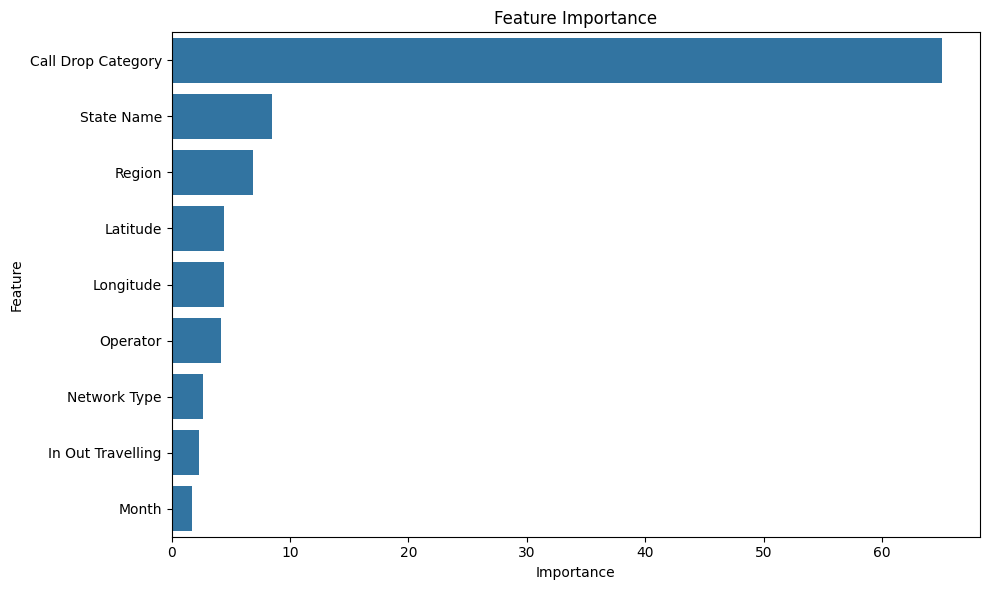

In [421]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Inference
The model is heavily driven by Call Drop Category, followed by State Name and Region. Geographical features (latitude, longitude, and region) and telecom-related features (operator and network type) also play significant roles, while temporal factors like Month are less important. This suggests that the model is sensitive to network performance and geographical factors, with limited influence from time-related trends.

In [132]:
# To deploy the model - importing the pickle file and using the trained model
import pickle

In [332]:
# Save the trained model to a pickle file
with open("xgbc_model.pkl", "wb") as file:
    pickle.dump(best_model_xgbc_cw, file)  

In [399]:
best_model_xgbc_cw

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)